In [5]:
from data_reading import *

In [6]:
lep_author_data['AUTHOR'] = lep_author_data['AuthorLastname'] + ' ' + lep_author_data['AuthorInitials']
#ipd.display(lep_author_data)

In [7]:
lep_first = lep_author_data[lep_author_data['AuthorN'] == 1]
lep_first_count = lep_first['AUTHOR'].value_counts().reset_index()
lep_first_count.columns = ['Author', 'Count']

lep_other = lep_author_data[lep_author_data['AuthorN'] != 1]
lep_other_count = lep_other['AUTHOR'].value_counts().reset_index()
lep_other_count.columns = ['Author', 'Count']

merged_lep = pd.merge(lep_first_count, lep_other_count, on='Author', how='outer', suffixes=(' First', ' Other')).fillna(0)
merged_lep['Count Sum'] = merged_lep['Count First'] + merged_lep['Count Other']

lep_descending = merged_lep.sort_values(by=['Count Sum'], 
                                        ascending = False, 
                                        ignore_index = True)

lep_top10 = lep_descending.iloc[:10,:]

ipd.display(lep_top10)

,Author,Count First,Count Other,Count Sum
0,Ko AI,1.0,85.0,86.0
1,Picardeau M,6.0,72.0,78.0
2,Lilenbaum W,6.0,71.0,77.0
3,Dellagostin OA,1.0,59.0,60.0
4,Reis MG,0.0,57.0,57.0
5,Vasconcellos SA,0.0,56.0,56.0
6,Hartskeerl RA,2.0,54.0,56.0
7,Koizumi N,14.0,42.0,56.0
8,Costa F,5.0,36.0,41.0
9,Goarant C,4.0,37.0,41.0


C:\Users\admin\AppData\Local\Temp\ipykernel_17092\626138135.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_countries))


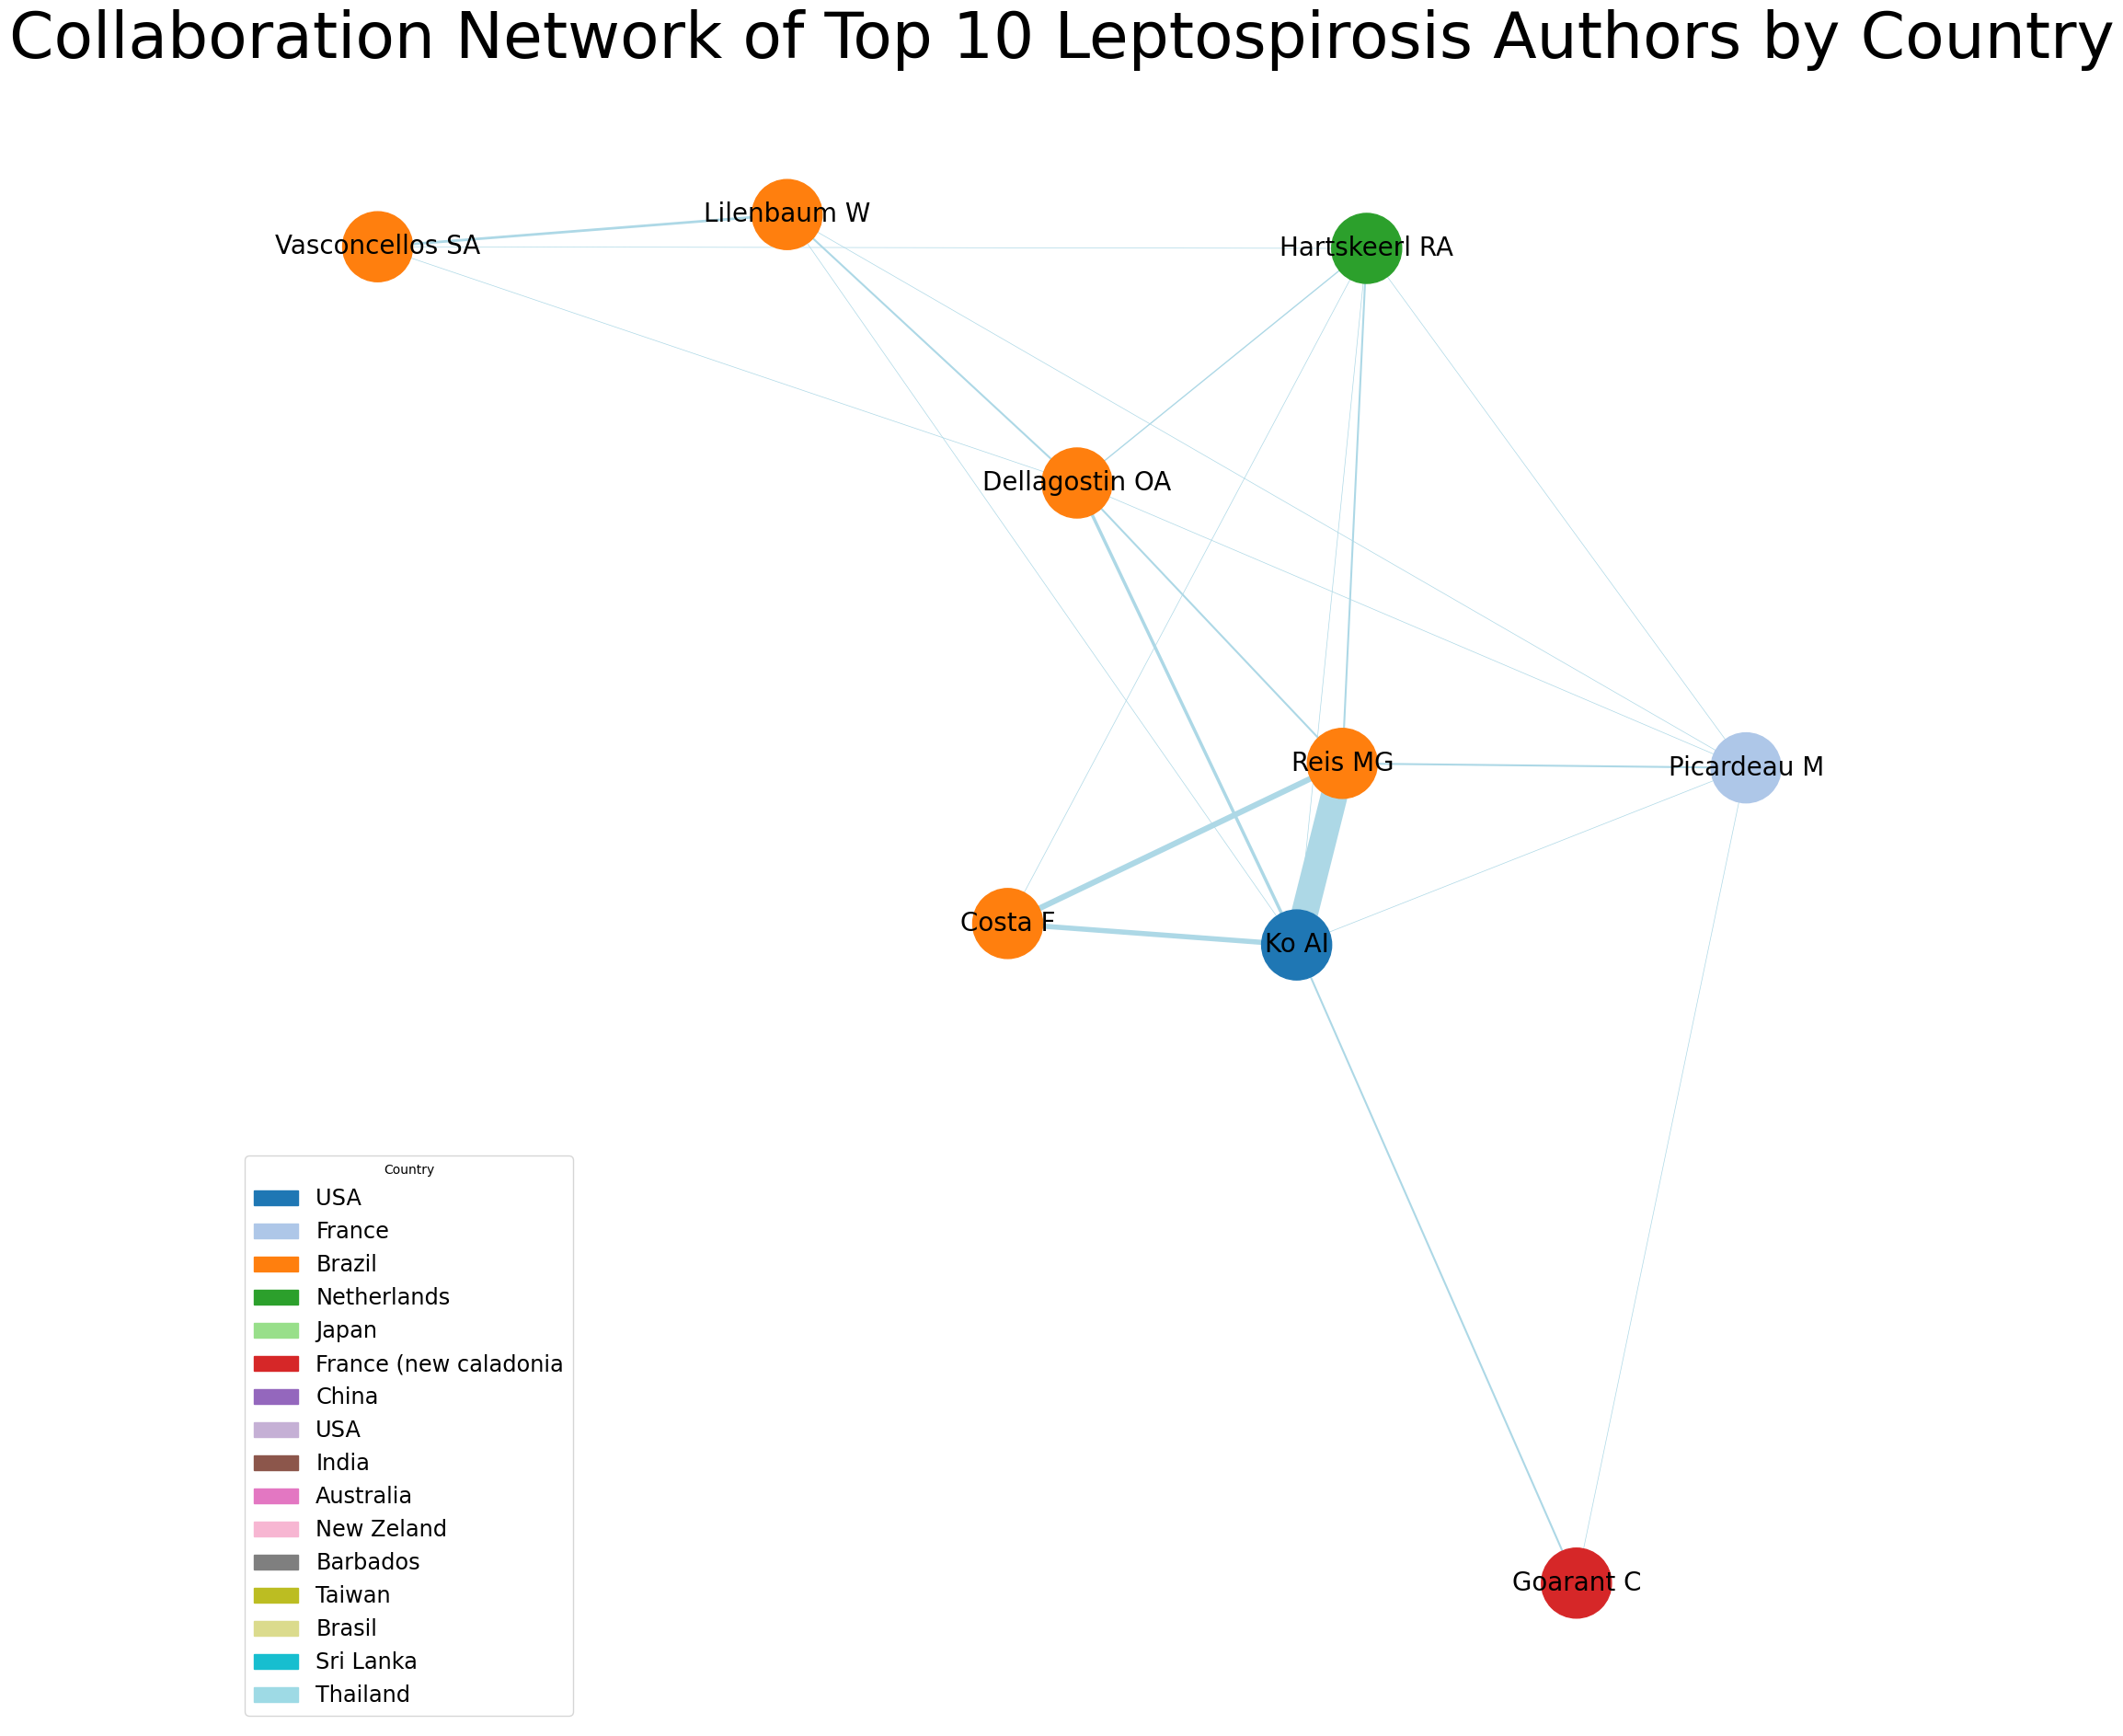

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming authors_data is the DataFrame containing the authors' information
# Create the 'AUTHOR' column by combining 'AuthorLastname' and 'AuthorInitials'
authors_data = pd.read_csv('C:\\Users\\admin\\Desktop\\group3\\Group 3\\authors.leptospirosis.csv')
authors_data['AUTHOR'] = authors_data['AuthorLastname'] + ' ' + authors_data['AuthorInitials']

# Create a list of tuples for co-author pairs
author_pairs = []

# Iterate through each article's authors to find pairs

for pmid in authors_data['PMID'].unique():
    authors_of_paper = authors_data[authors_data['PMID'] == pmid]['AUTHOR'].tolist()
    for i in range(len(authors_of_paper)):
        for j in range(i + 1, len(authors_of_paper)):
            pair = (authors_of_paper[i], authors_of_paper[j])
            author_pairs.append(pair)

# Create a DataFrame to count the frequency of each pair
author_pairs_df = pd.DataFrame(author_pairs, columns=['Author1', 'Author2'])
author_pairs_count = author_pairs_df.groupby(['Author1', 'Author2']).size().reset_index(name='Count')

# Filter to include only the top 20 authors
top_authors = set(lep_top10['Author'])  # Assuming lep_top20 is already defined
filtered_pairs = author_pairs_count[author_pairs_count['Author1'].isin(top_authors) & author_pairs_count['Author2'].isin(top_authors)]
country_data = pd.read_csv('C:\\Users\\admin\\Desktop\\top50_country.csv')

# Create a network graph
G = nx.Graph()

# Add nodes and edges with weights based on collaboration frequency
for index, row in filtered_pairs.iterrows():
    G.add_edge(row['Author1'], row['Author2'], weight=row['Count'])

country_info = country_data[['Author', 'country']]
author_country_map = dict(zip(country_info['Author'], country_info['country']))
# unique_countries = country_info['country'].unique()
# unique_countries = country_info['country'].drop_duplicates()
unique_countries=(country_info['country'].drop_duplicates()).dropna()
colors = plt.cm.get_cmap('tab20', len(unique_countries))
country_color_map = {country: colors(i) for i, country in enumerate(unique_countries)}
# print(unique_countries)

# Update the network graph with colored nodes based on country
node_colors = [country_color_map.get(author_country_map.get(author, 'Unknown'), 'grey') for author in G.nodes]

# Create a legend mapping colors to countries
legend_handles = [mpatches.Patch(color=color, label=country) for country, color in country_color_map.items()]

# Draw the graph with legend
plt.figure(figsize=(18, 18))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color=node_colors,font_size=20, node_size=3000, edge_color='lightblue', width=[(G[u][v]['weight']/2) for u,v in G.edges])
plt.title("Collaboration Network of Top 10 Leptospirosis Authors by Country",fontsize=50)
plt.legend(handles=legend_handles, title="Country", loc='lower left',fontsize='xx-large')
plt.show()
